<a href="https://colab.research.google.com/github/rdgreene/CNN-Workshop/blob/master/CNN_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title <--- Run this to download data and initialise your environment { display-mode: "form" }
%%capture

import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# # cats vs dogs data prep
!git clone https://ronangreene@bitbucket.org/ronangreene/cats_vs_dogs.git # clone repository with cats and dogs images
!unzip cats_vs_dogs/data.zip # unzip data in clones repo
!rm -r cats_vs_dogs # remove zipped data

train_dir = 'data/train'
val_dir = 'data/val'
test_dir = 'data/test'

# mnist data prep
from keras.datasets import mnist
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

(X, y), _ = mnist.load_data()
if K.image_data_format() == 'channels_first':
    X = X.reshape(X.shape[0], 1, target_size, target_size)
    input_shape = (1, 28, 28)
else:
    X = X.reshape(X.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)
X = X.astype('float32')
X /= 255

# convert class vectors to binary class matrices
y = to_categorical(y, 10)

mnist_data = (X, y)

## Task 1: Cat vs Dog Classification
For our first task, we have prepared a dataset containing labelled images of cats and dogs, and we will walk you through how to build an algorithm to differentiate between the two. A sample of these images is shown below.

### Intro to Keras
Keras is a Python package for deep learning package that cuts through a lot of the nitty gritty of programming deep learning models. There are a few different ways to use keras, but we will be using it to make sequential models, where we add layers to the model one at a time. You can find all of the keras documentation [here](https://keras.io/). We start by importing the various Keras sub-packages that we need for this workshop.

In [2]:
# import required Keras sub-packages
%tensorflow_version 2.x
from tensorflow.keras.preprocessing import image # used for image processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator # used for generating input data from our image directory
from tensorflow.keras import models # used for creating our model
from tensorflow.keras import layers # used for adding layers to our model
from tensorflow.keras import optimizers # used for training our model

TensorFlow is already loaded. Please restart the runtime to change versions.


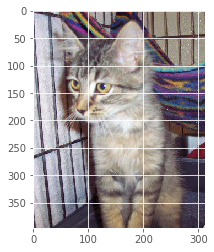

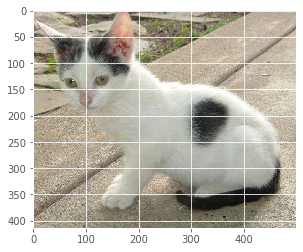

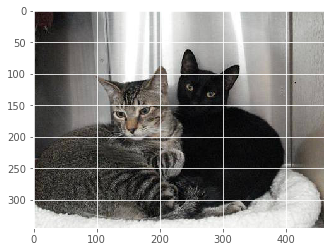

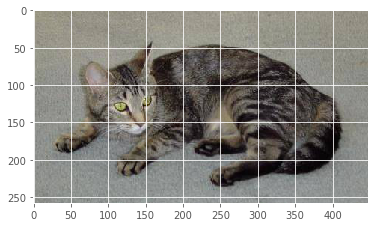

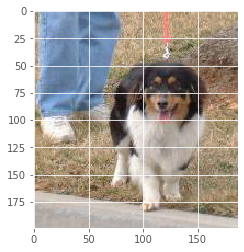

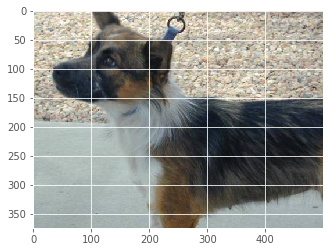

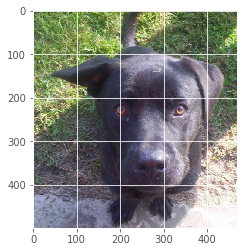

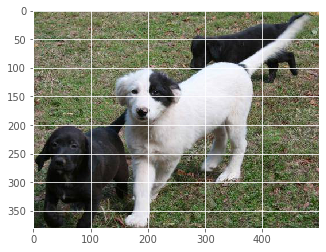

In [0]:
#@title A sample of our cat and dog images! { vertical-output: true }
for animal in ['cat', 'dog']:
  for i in ['2', '3', '8', '16']:
    plt.figure()
    plt.imshow(image.load_img(f'data/train/{animal}s/{animal}.{i}.jpg'))

### Defining the Model Architecture
Once we've imported all the sub-packages we need, we can proceed to define a CNN model as a sequence of convolutional, maxpooling, and dense layers. Once this is done the model is compiled for use.

In [4]:
# this defines the input size of the images we will be feeding into our model
target_size = 64

# create an instance of a sequential model
model = models.Sequential()

# add a first block of convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(target_size, target_size, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# add a second block of convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# add a third block of convolutional layers
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# add a final dense layer for classification
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# compile the model ready for training
model.compile(
    loss='binary_crossentropy', # determines how errors are measured
    optimizer='adam', # determines gradient descent algorithm used
    metrics=['accuracy'] # metric used to monitor model performance during training
    )

# print out a summary of the compiled model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)             

### Setting up our data feed

Next we want to use Keras' ImageDataGenerator object to feed image data into our CNN model direct from the image directory. We set up flows from two seperate directories, one containing training images, and the other containing validation images. The training images are used for directly training the model, while that validation images are used to evaluate how well the trained model generalises to images it did not see during training!

In [6]:
# create image generator instance
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# setup flow for training images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(target_size, target_size),
    batch_size=64,
    class_mode='binary'
    )

# setup flow for validation images
validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(target_size, target_size),
    batch_size=32,
    class_mode='binary'
    )

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Training the model

Once the model is compiled we can begin training the model. During this process the training images are fed through the model in batches, with the model predicting the class of each image in the batch. After processing a batch, the weights in the network are updated by backpropogating the classification errors from that particular batch. This occurs for a total of 20 epochs in this example, where one epoch is defined as a single pass over all the images in the training dataset. Throughout this whole process, the validation images are used to evaluate how well the model is doing at classifying images that it has not been exposed to during training. 

Note: It is usual to observe that the accuracy of the model when classifying validation images is less than that when classifying training images.

In [7]:
# train the model and record the results
results = model.fit_generator(
      train_generator,
      epochs=20,
      validation_data=validation_generator,
  )

Epoch 1/20
47/47 [==============================] - 26s 562ms/step - loss: 0.6969 - acc: 0.5323 - val_loss: 0.6858 - val_acc: 0.5800
Epoch 2/20
47/47 [==============================] - 24s 517ms/step - loss: 0.6694 - acc: 0.5793 - val_loss: 0.6583 - val_acc: 0.5920
Epoch 3/20
47/47 [==============================] - 24s 516ms/step - loss: 0.6247 - acc: 0.6580 - val_loss: 0.6490 - val_acc: 0.6360
Epoch 4/20
47/47 [==============================] - 24s 516ms/step - loss: 0.5940 - acc: 0.6913 - val_loss: 0.6258 - val_acc: 0.6710
Epoch 5/20
47/47 [==============================] - 24s 515ms/step - loss: 0.5417 - acc: 0.7350 - val_loss: 0.6072 - val_acc: 0.6670
Epoch 6/20
47/47 [==============================] - 24s 516ms/step - loss: 0.5016 - acc: 0.7590 - val_loss: 0.6063 - val_acc: 0.6910
Epoch 7/20
47/47 [==============================] - 24s 519ms/step - loss: 0.4577 - acc: 0.7817 - val_loss: 0.6630 - val_acc: 0.6490
Epoch 8/20
47/47 [==============================] - 24s 520ms/step - 

### Model evaluation

Now that the model has finished training, we can look at the results. Here we examine the accuracy of the model in classifying both training and validation images, as measured at the end of each epoch. We should observe that while performance on the training data is very strong, performance on the validation data plateaus after a number of epochs. This is a common problem in the machine learning field referred to as "overfitting". Overfitting is a problem as it suggests that some features learned by the model to discriminate between cats and dogs do not generalise well to the wider population on which we will want to deploy the trained model.

Dealing with overfitting is beyond the scope of this workshop, however there are a number of established approaches for doing this. In the context of CNNs, [dropout](http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf) and image augmentation are generally the go-to choices. If you wish to expriement with these approaches, Keras provides easy functionality for applying both (refer to the Keras documentation for more detail).

In instances where performance on our training data was not so strong, we might also want to experiment with the architecture of our model and various other parameters, as these can all have a substantial impact on performance. A good first step here is to increase the "size" of the model, which can be done by adding additional layers, or by making the layers themselves bigger.

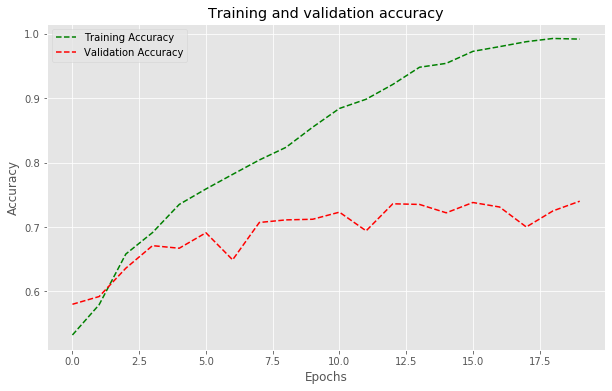

In [8]:
# get accuracy metrics recorded on training and validation images after each epoch
train_accuracy = results.history['acc']
val_accuracy = results.history['val_acc']
epochs = range(len(train_accuracy))

# plot accuracy metrics
plt.figure(figsize=(10,6))
plt.plot(epochs, train_accuracy, 'g--', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r--', label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

### Transfer Learning

An alternative approach to deep learning on image datasets is to use a model pre-trained on another image dataset and retrain the final layers for the specific task at hand. This approach is commonly known as "transfer learning".

Typically the pre-trained models used for this purpose have been previously trained on very large datasets, where the images are general enough that the feature identifying transformations learned by the lower layers can be of use for other image classification problems. This can be particularly beneficial when the dataset we have for a particular problem is small, which makes training good models from scratch is difficult.

Keras comes packaged with a number of pre-trained CNNs in its applications sub-package. Here we make use of the [MobileNet](https://arxiv.org/pdf/1704.04861.pdf) model, which was trained extensively on the ImageNet dataset (over 1 million labeled from 1000 different classes).

The basic workflow here consists of creating an instance of the pre-trained model with the final dense layers removed. We then create a new model using this pre-trained model as a base, adding our own dense layers on top. When training the model, the weights in the pre-trained part of the model are frozen, and we only learn the weights in the new dense layers that we have added on top.

In [15]:
# import the pretrained MobileNet model from the Keras applications library
from tensorflow.keras.applications import MobileNet

# create an instance of the MobileNet model with the final dense layers removed
mnet = MobileNet(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# print out a summary of the compiled model
mnet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 65, 65, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32) 

When we succesfully add our new layers on top of the MobileNet base, we should observe from the model summary that only a fraction of the parameters are trainable. These are the weights in the new dense layers that we have added.

In [16]:
# build a new model using MobileNet as a base and adding new dense layers on top
model = models.Sequential()
model.add(mnet)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# freeze parameters in the MobileNet base so that only parameters in the dense layers are learned when training
mnet.trainable = False

# compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# print out a summary of the compiled model
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 2, 2, 1024)        3228864   
_________________________________________________________________
flatten_4 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               1048832   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 4,277,953
Trainable params: 1,049,089
Non-trainable params: 3,228,864
_________________________________________________________________


We train our "transfer learning" model for a total of 5 epochs. As we are leveraging the power of the pre-trained network, we should see promising results quickly.

Epoch 1/10
47/47 [==============================] - 38s 801ms/step - loss: 1.0055 - acc: 0.6703 - val_loss: 0.4453 - val_acc: 0.7980
Epoch 2/10
47/47 [==============================] - 34s 727ms/step - loss: 0.4312 - acc: 0.7943 - val_loss: 0.4564 - val_acc: 0.7940
Epoch 3/10
47/47 [==============================] - 34s 716ms/step - loss: 0.3823 - acc: 0.8330 - val_loss: 0.6018 - val_acc: 0.7490
Epoch 4/10
47/47 [==============================] - 34s 728ms/step - loss: 0.3495 - acc: 0.8373 - val_loss: 0.4892 - val_acc: 0.7830
Epoch 5/10
47/47 [==============================] - 34s 722ms/step - loss: 0.2749 - acc: 0.8877 - val_loss: 0.5599 - val_acc: 0.7600
Epoch 6/10
47/47 [==============================] - 34s 726ms/step - loss: 0.2299 - acc: 0.9043 - val_loss: 0.7300 - val_acc: 0.7430
Epoch 7/10
47/47 [==============================] - 34s 724ms/step - loss: 0.1845 - acc: 0.9327 - val_loss: 0.7542 - val_acc: 0.7390
Epoch 8/10
47/47 [==============================] - 34s 723ms/step - 

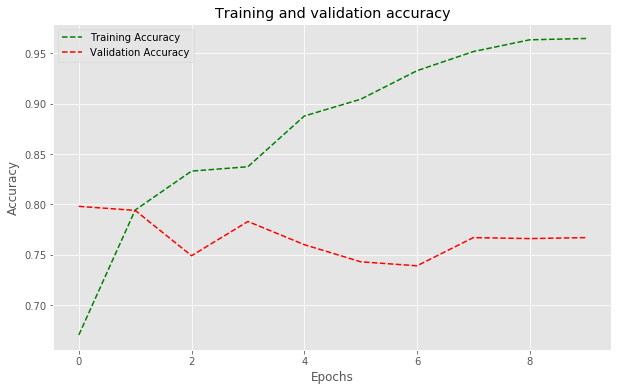

In [17]:
# train the model and record the results
results = model.fit_generator(
  train_generator,
  epochs=10,
  validation_data=validation_generator
  )

# plot results
train_accuracy = results.history['acc']
val_accuracy = results.history['val_acc']
epochs = range(len(train_accuracy))
plt.figure(figsize=(10,6))
plt.plot(epochs, train_accuracy, 'g--', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r--', label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

# Task 2: Handwritten Digit Classification

For our second task we will train a model to classify hand written digits between 0 and 9. To do this we make use of the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), which contains 60,000 examples of handwritten digits. MNIST is a well known dataset that has historically been used to benchmark computer vision algorithms, and as such provides a good demonstration of the power of CNNs. In this task you will build your own models by adding layers yourselves. The code to train the data on the MNIST dataset and plot the results is already provided. You just need to create a model instance, add some layers, and compile the model. 

There are a few key difference in relation to the last task that you should be aware of here. While Task 1 was a binary classification task (i.e. cat or dog), this task is a multitask classification problem, meaning there are many possible classes for each image (10 in this instance). In addition Task 1 used RGB images which have 3 channels, while this task uses greyscale images, which only have 1 channel. Because of these nuances, there are some important changes you will need to make in terms of defning the input shape and loss funciton of your model. Hints have been provided in the code comments.

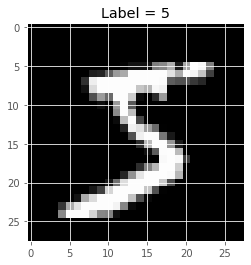

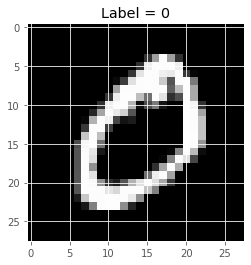

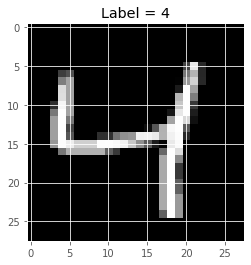

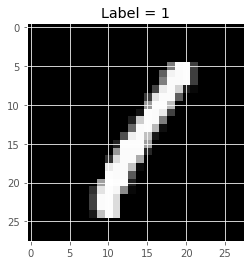

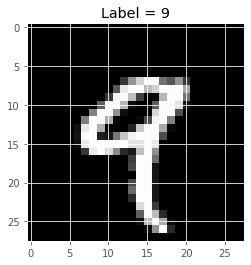

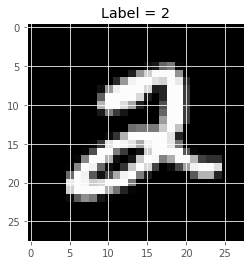

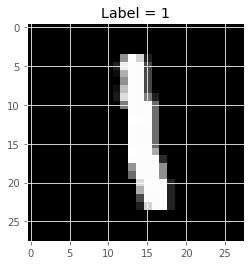

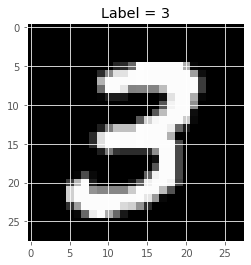

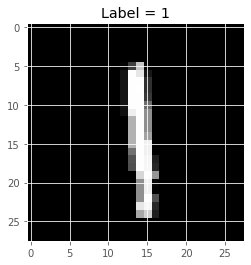

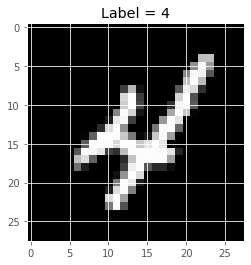

In [18]:
#@title <--- Show  a sample of MNIST digit images
X, y = mnist_data

for i in range(10):
    plt.imshow(X[i].reshape(28, 28),cmap='gray')
    plt.title(f'Label = {np.argmax(y[i])}')
    plt.show()

In [19]:
# this defines the input size of the images we will be feeding into our model
target_size = 28

# 1. Create an instance of a sequential model
pass

# 2. Add blocks of convolutional layers (use input_shape=(target_size, target_size, 1) for first convolusitonal layer)
pass

# 3. Add dense layers for classification (layers.Dense(10, activation='softmax') for final layer)
pass

# 4. Compile the model (use loss='categorical_crossentropy' as multiclass problem)
pass

# train the model for 5 epochs using 20% of the data for validation
results = model.fit(X, y, epochs=10, validation_split=0.2, batch_size=128)

# this will print the training results at the end
train_accuracy = results.history['acc']
val_accuracy = results.history['val_acc']
epochs = range(len(train_accuracy))
plt.figure(figsize=(10,6))
plt.plot(epochs, train_accuracy, 'g--', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r--', label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

ValueError: ignored